# Conceptual Design Sizing

## Main Sizing



$$$$$$$$$$ Debugging $$$$$$$$$$

=== mission two stuffs ===
Drag buildup... 
> cd_fus_tof: 0.0020764309441883315, cd_fus_cruise: 0.001899762901721136
> cd_tof: 0.09278608253010354, cd_cruise: 0.05023498806669469
> D_tof: 3.884766171488883, D_cruise: 5.1877016674893595, D_turn: 6.989918242173769
Power buildup... 
> P_motor_tof: 187.3584441051429, P_motor_cruise: 215.12433902568222, P_motor_turn: 289.85890825501576
climb rate: 3.202725158871953
Course params... 
> t_tof: 3.78729179097358, t_climb: 3.122340976495825, t_cruise: 458.8626749929557

=== mission three stuff ===
Drag buildup... 
> cd_fus_tof: 0.002030553704806437, cd_fus_cruise: 0.0020054358834559545
> cd_tof: 0.29274020529072164, cd_cruise: 0.3863119942344345
> cd_banner_tof: 0.2, cd_banner_cruise: 0.30466680672531626
> D_tof: 15.205032410674313, D_cruise: 22.6946254984128, D_turn: 23.445022631603543
Power buildup... 
> P_motor_tof: 404.229204342344, P_motor_cruise: 709.8157734178312, P_motor_turn: 733.2858113571468
> climb r

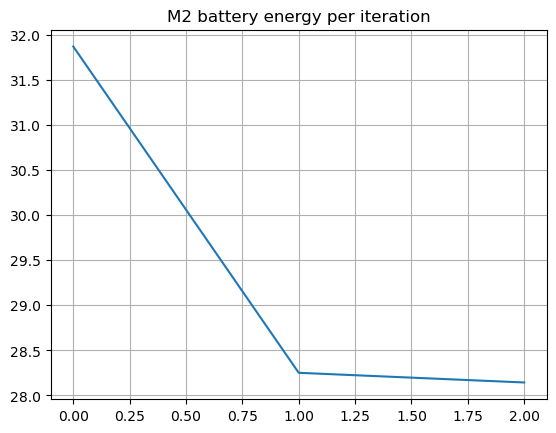

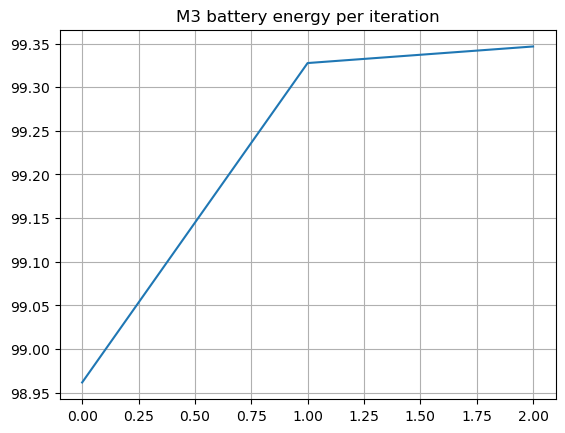

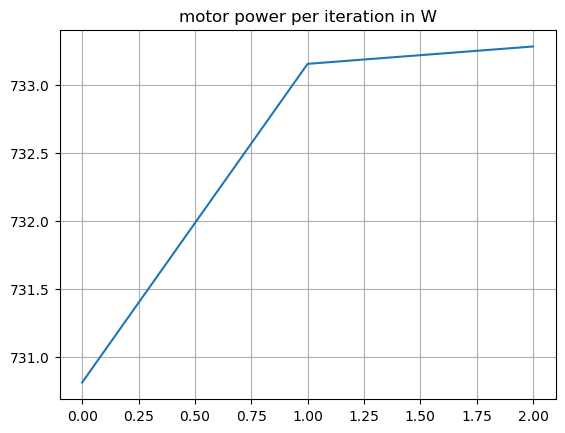

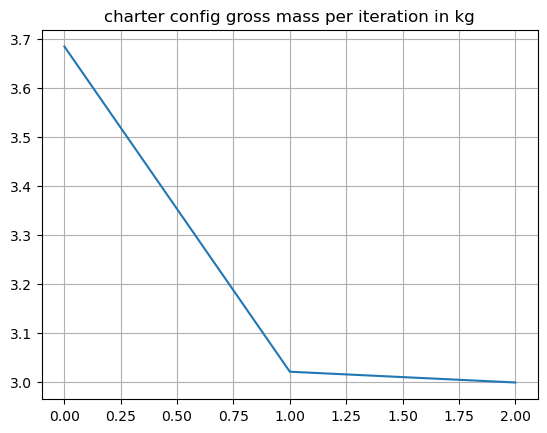

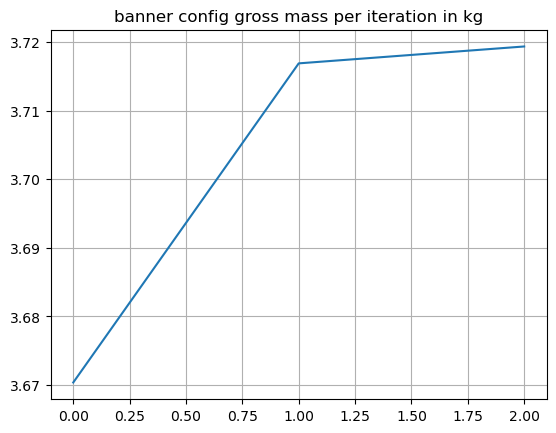

In [1]:
from constraint_analysis.sizing import aircraft
import numpy as np
import yaml
import matplotlib.pyplot as plt
import pandas as pd

conditions = { 'altitude asl':397,'cruise altitude agl':10}
aircraft_design_parameters = {'aspect ratio' : 3.644246,'wing span':1.524,'CLmax':0.85,'CDmin_no_fuselage':0.04,'fineness ratio':6,'m2 bank angle':0.96607, 'm3 bank angle': 0.5163}
aircraft_design_parameters['conditions'] = conditions
mission_parameters = {'cargo':1,'ducks':3,'mission two cruise speed': 16.587256,'banner length':8.3,'mission three cruise speed':12.510729,'banner aspect ratio':5}
course_parameters = {'ground run': 20,'time limit': 300,'length of straights': 304.8 }
initial_guess = {'motor mass': 0.1,'m2 battery mass': 0.8,'m3 battery mass':0.5}

my_plane=aircraft(aircraft_design_parameters, mission_parameters, course_parameters, initial_guess, banner_data='docs/banner_data.yaml')

my_plane.size_aircraft_all_missions(show_summary=True, debug_text=True)

print('\n\n')
# print(my_plane.eff_system_cruise)
# print(my_plane.drag_m3_cruise)
# print(my_plane.drag_m3_turn)

print(my_plane.l)
print(my_plane.d)
print(my_plane.mass_m1_gross)
print(my_plane.mass_m2_gross)
print(my_plane.mass_m3_gross) 
print(f'wing: {my_plane.mass_wing}, tail: {my_plane.mass_tail}, landing_gear: {my_plane.mass_landing_gear}, fuselage: {my_plane.mass_fuselage}, motor: {my_plane.mass_motor}, m2_battery: {my_plane.mass_m2_battery}, m3_battery: {my_plane.mass_m3_battery}')  
print(my_plane.mass_banner)
print(f'ducks: {my_plane.mass_ducks}, cargo: {my_plane.mass_cargo}')
print(f'avionics: {my_plane.mass_propulsion_electronics}, banner elecronics: {my_plane.banner_stowing_electronics}')

print(f'mission three \ncruise energy: {my_plane.E_m3_cruise}, takeoff energy: {my_plane.E_m3_tof}, climb_energy: {my_plane.E_m3_climb}')
temp = (my_plane.E_m3_cruise + my_plane.E_m3_tof + my_plane.E_m3_climb ) /0.75
print(temp)
print(f'legnth m3 turn: {my_plane.L_m3_turn}')
temp2 = my_plane.mass_m3_gross*9.81 / (1/2*my_plane.V_m3_cruise**(2)*my_plane.S)
temp3 = my_plane.mass_m3_gross*9.81 / (1/2*(my_plane.V_m3_cruise/0.95)**(2)*my_plane.S) 
print(temp2)
print(temp3)
print(my_plane.eff_battery_cruise, my_plane.eff_esc_cruise)

## Tail Sizing


=== Tail Summary ===

l_tail = 1.660 m
l_boom = 1.446 m
r_boom = 0.500 in

Horizontal Tail:
AR = 3.323
S = 0.082 m^2
b = 0.522 m
c = 0.157 m

Vertical Tail:
AR = 1.460
S = 0.032 m^2
b = 0.215 m
c = 0.157 m 



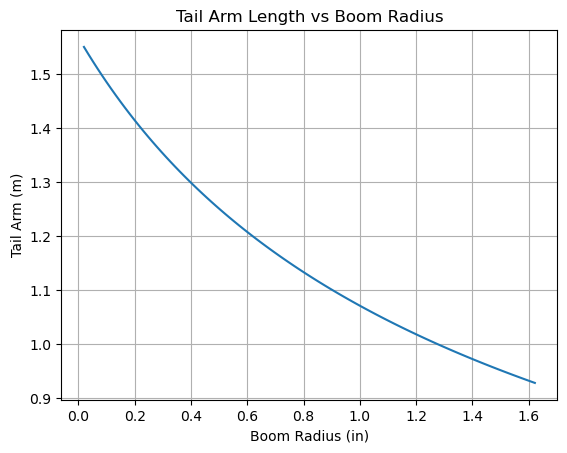

In [ ]:
def size_tail_arm(V_ht, V_vt, r_boom):
    """ Size tail arm to reduce wetted drag from boom 
    S_wet_tube = 2*pi*r_boom*l_tail
    assume the boom star """
    S_wet_fus = my_plane.wing_chord * 3/4 * my_plane.d * 4 + np.pi*(my_plane.d + 2*r_boom)*l_fus_aft_te
    l_tail = np.sqrt(2*my_plane.wing_area*(V_ht*my_plane.wing_chord + V_vt*my_plane.wing_wingspan) / (S_wet_fus + 2*np.pi*r_boom))
    return l_tail
# print(my_plane.wing_area, my_plane.wing_chord, my_plane.wing_wingspan)
with open('docs/tail_volumes.yaml', 'r') as file:
    tail_data = yaml.safe_load(file)

V_ht_avg = np.mean(tail_data[2020]['V_ht'])
V_vt_avg = np.mean(tail_data[2020]['V_vt'])
AR_ht_avg = np.mean(tail_data[2020]['AR_ht'])
AR_vt_avg = np.mean(tail_data[2020]['AR_vt'])

l_fus_aft_te = 0.1
r_min = 0.0254*0.039/2
r_max = 0.0254*3.244/2
r_boom_arr = np.linspace(r_min, r_max, 100)
l_tail_arr = size_tail_arm(V_ht_avg, V_vt_avg, r_boom_arr)

plt.plot(r_boom_arr/0.0254, l_tail_arr)
plt.xlabel('Boom Radius (in)')
plt.ylabel('Tail Arm (m)')
plt.title('Tail Arm Length vs Boom Radius')

# Assume the boom is a 1/2" radius
# l_tail = size_tail_arm(V_ht_avg, V_vt_avg, 0.0254*0.5)
l_tail = my_plane.l_banner/my_plane.AR_banner
l_boom = l_tail - my_plane.wing_chord * 3/4 + l_fus_aft_te


# Tail dimensions:
S_ht = V_ht_avg * my_plane.wing_chord * my_plane.wing_area / l_tail
b_ht = np.sqrt(S_ht * AR_ht_avg)
c_ht = S_ht / b_ht

S_vt = V_vt_avg * my_plane.wing_wingspan * my_plane.wing_area / l_tail
b_vt = np.sqrt(S_vt * AR_vt_avg)
c_vt = S_vt / b_vt

# Summary
print(f'=== Tail Summary ===\n\nl_tail = {l_tail:.3f} m\nl_boom = {l_boom:.3f} m\nr_boom = {0.5:.3f} in\n\n'
      f'Horizontal Tail:\nAR = {AR_ht_avg:.3f}\nS = {S_ht:.3f} m^2\nb = {b_ht:.3f} m\nc = {c_ht:.3f} m\n\n'
      f'Vertical Tail:\nAR = {AR_vt_avg:.3f}\nS = {S_vt:.3f} m^2\nb = {b_vt:.3f} m\nc = {c_vt:.3f} m \n')
